We build a reduced order model (ROM) for the scattering of plane waves from different directions by a homogeneous square. First we set up the parameterised scattering model. As parameters, we take the incident wave direction (angle) and the side-length of the square.

In [1]:
# Import packages
import numpy as np
from scipy.special import hankel1
from scipy.sparse.linalg import LinearOperator, gmres
from analytical import penetrable_circle
from scipy.linalg import toeplitz
import time

In [2]:
ko = 1  # wavenumber (this is arbitrary since we define the shape size in terms of wavelengths)
lam = 2 * np.pi / ko  # wavelength
domain_width = 5 * np.pi
square_side = domain_width  # make side length of square equal to the domain width, can make it smaller if we wish

refInd = 1.1  # refractive index
n_per_lam = 10  # Pixels per wavelength

h_temp = lam / n_per_lam  # temp pixel dimension

wx = domain_width
wy = domain_width

from solver2d import geometry2d

x, Area, a, M, N, dx, dy = geometry2d(h_temp, wx, wy)

perm = np.ones(M*N)  # permittivities

# Find the indices of the pixels lying inside the square
IDX = (np.abs(np.real(x)) <= square_side/2) * \
      (np.abs(np.imag(x)) <= square_side/2)
idx = np.where(IDX)  # locate indices of points inside circle

perm[idx[0]] = refInd**2  # assume permittivity of scatterer is 2 for now
Mr = perm - 1

MR = Mr.reshape(M, N, order='F')

# Get Toeplitz operator
from solver2d import get_operator
toep = get_operator(Area, ko, x, a, M, N)

In [3]:
# Perform circulant embedding of Toeplitz matrix
from solver2d import circulant_embedding
opCirc = circulant_embedding(toep, M ,N)

In [4]:
# Define matrix-vector product and corresponding linear operator
def mvp(xIn):
    xInRO = xIn.reshape(M, N, order='F')
    XFFT = np.fft.fftn(xInRO, [2 * M, 2 * N])
    Y = np.fft.ifftn(opCirc * XFFT)
    xTemp = Y[0:M, 0:N]
    xPerm = MR * xTemp
    xOutArray = xInRO - xPerm
    xOut = np.zeros((M * N, 1), dtype=np.complex128)
    xOut[idx[0]] = (xOutArray.reshape(M * N, 1, order='F'))[idx[0]]
    return xOut


A = LinearOperator((M*N, M*N), matvec=mvp)

it_count = 0


def iteration_counter(x):
    global it_count
    it_count += 1

In [5]:
# Construct circulant approximation of Toeplitz matrix in x-direction
start = time.time()
from solver2d import circulant_preconditioner
circ_inv = circulant_preconditioner(toep, M, N, refInd)
end = time.time()
print('Preconditioner assembly time = ', end - start)

# Define matrix-vector product with circulant preconditoner
def mvp_circ(x, circ_inv, M, N, IDX):
    x_r = x
    # from IPython import embed; embed()
    x_r[np.invert(IDX)] = 0.0 
    x_rhs = x_r.reshape(M*N, 1, order='F')

    temp = x_rhs.reshape(M, N, order='F')
    temp = np.fft.fft(temp, axis=0).T
    for i in range(0, M):
        temp[:, i] = np.matmul(circ_inv[i, :, :], temp[:, i])

    temp = np.fft.ifft(temp.T, axis=0)
    TEMP = temp.reshape(M*N, 1, order='F')
    TEMP_RO = TEMP
    TEMP_RO[np.invert(IDX)] = 0.0 + 0.0j
    matvec = TEMP_RO.reshape(M*N, 1, order='F')
    return matvec

idx_all = np.ones((M*N, 1), dtype=bool)
mvp_prec = lambda x: mvp_circ(x, circ_inv, M, N, IDX[:, 0])

prec = LinearOperator((M*N, M*N), matvec=mvp_prec)

Preconditioner assembly time =  0.019343137741088867


In [7]:
# Perform solves for a range of incident plane wave directions
n_angle = 100
# Save solutions as columns in a matrix
sol_matrix = np.zeros((M * N, n_angle), dtype=np.complex128)
angle = np.linspace(0, np.pi, n_angle)
eInc = np.zeros((M * N, 1), dtype=np.complex128)
for i in range(n_angle):
    dInc = np.array([np.cos(angle[i]), np.sin(angle[i])])
    eInc[idx[0]] = np.exp(1j * ko * (np.real(x[idx[0]]) * dInc[0] +
                      np.imag(x[idx[0]] * dInc[1])))
    solp, info = gmres(A, eInc, M=prec, tol=1e-14)
    sol_matrix[:, i] = solp

In [8]:
# Take the SVD of the sol_matrix to see if a reduced order model could work
# Perform reduced SVD
u_, s_, vh_ = np.linalg.svd(sol_matrix, full_matrices=False)

In [9]:
# %matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.use('Agg')
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10, 8))
# plt.rc('text', usetex=True)
plt.semilogy(s_/s_[0])
plt.show()

In [10]:
# Keep the first n_sing left-singular vectors
n_sing = 30
P = u_[:, 0:n_sing]
P.shape

(625, 30)

In [11]:
# Create reduced matrix
R = np.matmul(np.conjugate(P).T, A(P))

In [12]:
# Solve reduced system for each right-hand side
sol_ROM = np.zeros((M*N, n_angle), dtype=np.complex128)
eInc = np.zeros((M * N, 1), dtype=np.complex128)
for i in range(n_angle):
    dInc = np.array([np.cos(angle[i]), np.sin(angle[i])])
    eInc[idx[0]] = np.exp(1j * ko * (np.real(x[idx[0]]) * dInc[0] +
                      np.imag(x[idx[0]] * dInc[1])))
    # Project down the right-hand side vector
    rhs = np.matmul(np.conjugate(P).T, eInc)
    # Solve ROM
    u_ROM = np.linalg.solve(R, rhs)
    u_R = np.matmul(P, u_ROM)
    sol_ROM[:, i] = u_R[:,0]

In [15]:
# Compute accuracy of POD-ROM solutions
errors = np.zeros(n_angle)
for i in range(n_angle):
    errors[i] = np.linalg.norm(sol_matrix[:, i]-sol_ROM[:, i]) / np.linalg.norm(sol_matrix[:, i])

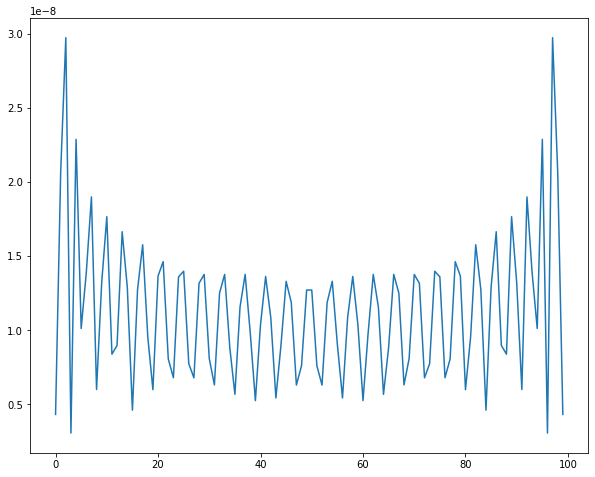

In [16]:
fig = plt.figure(figsize=(10, 8))
# plt.rc('text', usetex=True)
plt.plot(errors)
plt.show()

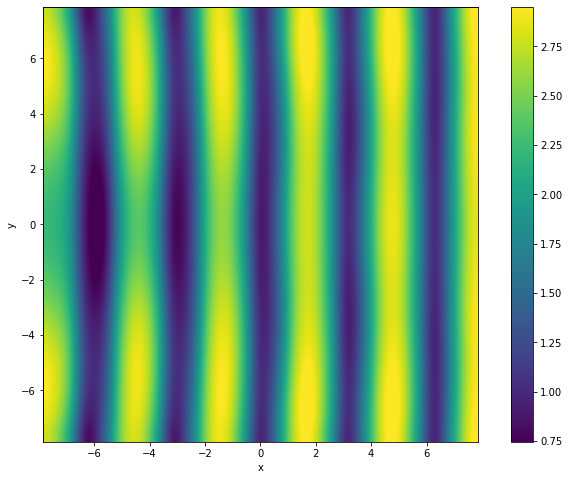

In [38]:
# Post-processing for evaluating the total field in the domain
def mvp_domain(xIn, opCirc, M, N, MR):
    xInRO = xIn.reshape(M, N, order='F')
    XFFT = np.fft.fftn(MR * xInRO, [2*M, 2*N])
    Y = np.fft.ifftn(opCirc * XFFT)
    xTemp = Y[0:M, 0:N]
    xPerm = xTemp
    xOutArray = xInRO - xPerm
    xOut = np.zeros((M * N, 1), dtype=np.complex128)
    xOut = (xOutArray.reshape(M*N, 1, order='F'))
    return xOut


xmin, xmax, ymin, ymax = [-wx/2+dx/2, wx/2-dx/2, -wy/2+dy/2, wy/2-dy/2]
plot_grid = np.mgrid[xmin:xmax:M * 1j, ymin:ymax:N * 1j]

mvp_eval = mvp_domain(sol_matrix[:, 0], opCirc, M, N, MR)

EINC = np.zeros((M * N, 1), dtype=np.complex128)
EINC = np.exp(1j * ko * (np.real(x)*dInc[0] + np.imag(x*dInc[1])))

E_tot = EINC.reshape(M, N, order='F') \
    - mvp_eval.reshape(M, N, order='F') \
    + solp.reshape(M, N, order='F')

E = mvp_eval.reshape(M, N, order='F')

verts = np.array([[-square_side/2, -square_side/2],
                  [-square_side/2, square_side/2],
                  [square_side/2, square_side/2],
                  [square_side/2, -square_side/2]])

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
# plt.imshow(np.abs(E_tot.T), extent=[-wx/2,wx/2,-wy/2,wy/2],
#            cmap=plt.cm.get_cmap('viridis'), interpolation='spline16')
plt.imshow(np.abs(solp.reshape(M, N)), extent=[-wx/2,wx/2,-wy/2,wy/2],
           cmap=plt.cm.get_cmap('viridis'), interpolation='spline16')
polygon = Polygon(verts, facecolor="none", 
              edgecolor='black', lw=0.8)
plt.gca().add_patch(polygon)

plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

Now let's try train a neural network for the MOR instead of using POD

In [21]:
import tensorflow as tf

In [22]:
# Since the weights in TensorFlow are real (not complex), we have to split the real and imaginary parts of c, thereby doubling the number of items to fit
# Redefine sol_matrix as U to be consistent with my notes
U = sol_matrix
c = np.matmul(np.conjugate(P).T, U)

# Split c into real and imaginary parts and scale both
from sklearn.preprocessing import MinMaxScaler
scaler_real = MinMaxScaler(feature_range=(0, 1))
scaler_imag = MinMaxScaler(feature_range=(0, 1))
c_real_scaled = scaler_real.fit_transform(np.real(c.T)).T
c_imag_scaled = scaler_imag.fit_transform(np.imag(c.T)).T

# max_real = np.max(np.real(c))
# min_real = np.min(np.real(c))
# max_imag = np.max(np.imag(c))
# min_imag = np.min(np.imag(c))
# c_real_scaled = (np.real(c) - min_real) / (max_real - min_real)
# c_imag_scaled = (np.imag(c) - min_imag) / (max_imag - min_imag)

c_split = np.concatenate((c_real_scaled, c_imag_scaled), axis=0)
# c_split = np.concatenate((np.real(c) / np.max(np.real(c)), np.imag(c) / np.max(np.imag(c))), axis=0)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Split X,y into training and test data
c_train, c_test, y_train, y_test = train_test_split(c_split.T, angle, test_size=0.3)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(c_train.shape[1])
])

optimizer = tf.keras.optimizers.RMSprop(0.01)

model.compile(loss='mae',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

In [25]:
c_train.shape, y_train.shape

((70, 60), (70,))

In [26]:
model.fit(y_train, c_train, epochs=1000)

5ms/step - loss: 0.1289 - mae: 0.1289 - mse: 0.0340
Epoch 818/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1403 - mae: 0.1403 - mse: 0.0390
Epoch 819/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1555 - mae: 0.1555 - mse: 0.0463
Epoch 820/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1191 - mae: 0.1191 - mse: 0.0300
Epoch 821/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.1266 - mae: 0.1266 - mse: 0.0329
Epoch 822/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1436 - mae: 0.1436 - mse: 0.0415
Epoch 823/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.1429 - mae: 0.1429 - mse: 0.0385
Epoch 824/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1437 - mae: 0.1437 - mse: 0.0407
Epoch 825/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.1196 - mae: 0.1196 - mse: 0.0317
Epoch 826/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.

In [27]:
model.evaluate((y_test),  (c_test), verbose=2, steps=1)

1/1 - 0s - loss: 0.1583 - mae: 0.1583 - mse: 0.0438


[0.15830087661743164, 0.15830087661743164, 0.04377232491970062]

In [28]:
prediction = model.predict(angle)
# Split the prediction, then inverse transform the pieces
idx = 5
prediction_real = prediction[:, :n_sing]
# prediction_real = (max_real - min_real) * prediction_real + min_real
prediction_real = scaler_real.inverse_transform(prediction_real)

prediction_imag = prediction[:, n_sing:]
# prediction_imag = (max_imag - min_imag) * prediction_imag + min_imag
prediction_imag = scaler_imag.inverse_transform(prediction_imag)

In [29]:

predict = prediction_real + 1j * prediction_imag

In [30]:
predict.shape

(100, 30)

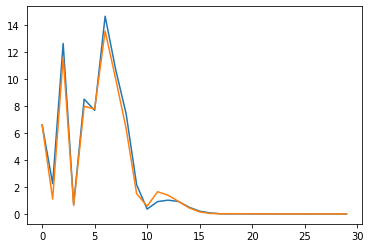

In [31]:
plt.plot(np.abs(predict[idx, :]))
plt.plot(np.abs(c[:, idx]))
plt.show()

In [32]:
solly_pred = np.matmul(P, predict[idx, :].T)
solly = np.matmul(P, c[:, idx])

In [33]:
kl = solly.reshape(M, N)
kk = solly_pred.reshape(M, N)

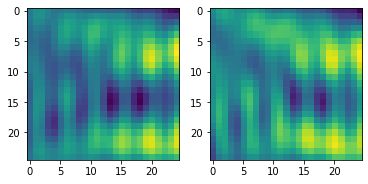

In [34]:
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(kl))

plt.subplot(122)
plt.imshow(np.abs(kk))

plt.show()

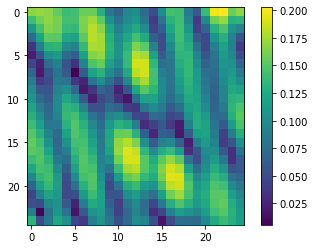

In [35]:
plt.imshow(np.abs(kl-kk) / np.abs(kl))
plt.colorbar()

In [36]:
np.linalg.norm(kk-kl) / np.linalg.norm(kl)

0.11348443255401879